In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        return x.to(dtype=torch.long)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "~/data", split = "trainval", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "~/data", split = "test", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


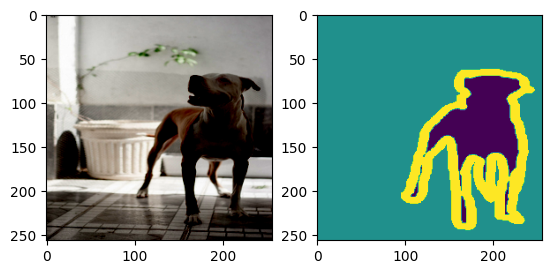

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.cpu().permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, 3, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [12]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)

            valid_gen_img = model(valid_img)
            valid_loss = loss_fn(valid_gen_img, valid_mask.squeeze(1))

            va_total_loss += valid_loss.item()

    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")

model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.71it/s]


Epoch: 0 - TrainLoss: 0.8611114148435921 - ValidLoss: 0.9705934175129595


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.76it/s]


Epoch: 1 - TrainLoss: 0.6128636763013643 - ValidLoss: 0.614409469324967


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.00it/s]


Epoch: 2 - TrainLoss: 0.5518133393649397 - ValidLoss: 0.5471072443600359


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch: 3 - TrainLoss: 0.4904132017801548 - ValidLoss: 0.4795256596187065


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch: 4 - TrainLoss: 0.43924174021030293 - ValidLoss: 0.4270664628209739


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  5.98it/s]


Epoch: 5 - TrainLoss: 0.4036457430699776 - ValidLoss: 0.3882654232197794


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.70it/s]


Epoch: 6 - TrainLoss: 0.3813812717281539 - ValidLoss: 0.46155835328430966


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.64it/s]


Epoch: 7 - TrainLoss: 0.3597037751099159 - ValidLoss: 0.43801450112770346


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.60it/s]


Epoch: 8 - TrainLoss: 0.35172388933855914 - ValidLoss: 0.3675190446705654


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.65it/s]


Epoch: 9 - TrainLoss: 0.3276313553596365 - ValidLoss: 0.3891575613926197


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.58it/s]


Epoch: 10 - TrainLoss: 0.31301635298235664 - ValidLoss: 0.3416473264324254


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.13it/s]


Epoch: 11 - TrainLoss: 0.3109232973435829 - ValidLoss: 0.348861632162127


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.68it/s]


Epoch: 12 - TrainLoss: 0.29864868367540426 - ValidLoss: 0.3105853092053841


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.36it/s]


Epoch: 13 - TrainLoss: 0.29190919394123144 - ValidLoss: 0.3140677187977166


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.56it/s]


Epoch: 14 - TrainLoss: 0.2804269988475175 - ValidLoss: 0.3304763487700758


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.50it/s]


Epoch: 15 - TrainLoss: 0.26341999913084096 - ValidLoss: 0.31166265596603526


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch: 16 - TrainLoss: 0.2610574523950445 - ValidLoss: 0.29405547755545586


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch: 17 - TrainLoss: 0.2525137236406063 - ValidLoss: 0.32626051532811134


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.64it/s]


Epoch: 18 - TrainLoss: 0.25052628100946034 - ValidLoss: 0.30106955406994657


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.41it/s]


Epoch: 19 - TrainLoss: 0.23694047537343255 - ValidLoss: 0.298938118178269


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.65it/s]


Epoch: 20 - TrainLoss: 0.2261945022077396 - ValidLoss: 0.3061739447815665


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.41it/s]


Epoch: 21 - TrainLoss: 0.22690921764949273 - ValidLoss: 0.29533601603631315


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch: 22 - TrainLoss: 0.21599157668393235 - ValidLoss: 0.30120426544855383


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.69it/s]


Epoch: 23 - TrainLoss: 0.20527477022902718 - ValidLoss: 0.2940141923468688


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.66it/s]


Epoch: 24 - TrainLoss: 0.19541790182220525 - ValidLoss: 0.28469128084593803


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.68it/s]


Epoch: 25 - TrainLoss: 0.19501055622922964 - ValidLoss: 0.3074143125579275


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.83it/s]


Epoch: 26 - TrainLoss: 0.18758558096556827 - ValidLoss: 0.3098577381721858


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.79it/s]


Epoch: 27 - TrainLoss: 0.18189805951611748 - ValidLoss: 0.28519856159029333


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.71it/s]


Epoch: 28 - TrainLoss: 0.17937126421722874 - ValidLoss: 0.309473035664394


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.71it/s]


Epoch: 29 - TrainLoss: 0.17883547061476215 - ValidLoss: 0.2920375972472388


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.79it/s]


Epoch: 30 - TrainLoss: 0.1697702294793622 - ValidLoss: 0.2964682584178859


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.68it/s]


Epoch: 31 - TrainLoss: 0.15953094152540997 - ValidLoss: 0.3426557208957343


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.70it/s]


Epoch: 32 - TrainLoss: 0.15772078391806832 - ValidLoss: 0.3031153789368169


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.76it/s]


Epoch: 33 - TrainLoss: 0.14809018913014182 - ValidLoss: 0.3026677308411434


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.66it/s]


Epoch: 34 - TrainLoss: 0.1443009021981009 - ValidLoss: 0.2980682657196604


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.68it/s]


Epoch: 35 - TrainLoss: 0.14115316677710105 - ValidLoss: 0.3261344201605895


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.71it/s]


Epoch: 36 - TrainLoss: 0.14216178938232618 - ValidLoss: 0.3027891180124776


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.64it/s]


Epoch: 37 - TrainLoss: 0.135422525734737 - ValidLoss: 0.3242870918635664


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.66it/s]


Epoch: 38 - TrainLoss: 0.13351787947889032 - ValidLoss: 0.3346471483337468


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.77it/s]


Epoch: 39 - TrainLoss: 0.13786394367444105 - ValidLoss: 0.3236654018019808


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.67it/s]


Epoch: 40 - TrainLoss: 0.13002414911471563 - ValidLoss: 0.32203437490709896


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 41 - TrainLoss: 0.12437012907246063 - ValidLoss: 0.3307325716676383


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 42 - TrainLoss: 0.12106697158566837 - ValidLoss: 0.3260752337759939


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.53it/s]


Epoch: 43 - TrainLoss: 0.1177902365552968 - ValidLoss: 0.3383165320445751


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.47it/s]


Epoch: 44 - TrainLoss: 0.113767653446773 - ValidLoss: 0.3410513647671404


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  5.97it/s]


Epoch: 45 - TrainLoss: 0.11226756703750841 - ValidLoss: 0.35046010592888144


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.36it/s]


Epoch: 46 - TrainLoss: 0.1109864931425144 - ValidLoss: 0.34083110993278437


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.73it/s]


Epoch: 47 - TrainLoss: 0.10801060176615057 - ValidLoss: 0.3519570801792474


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.67it/s]


Epoch: 48 - TrainLoss: 0.10692458509885032 - ValidLoss: 0.3598531011877389


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.58it/s]


Epoch: 49 - TrainLoss: 0.10444711033126404 - ValidLoss: 0.3575898527071394


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 50 - TrainLoss: 0.09973428372679086 - ValidLoss: 0.3686100408948701


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 51 - TrainLoss: 0.09734320884634709 - ValidLoss: 0.37834556246625967


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.63it/s]


Epoch: 52 - TrainLoss: 0.09690639710631864 - ValidLoss: 0.36053381757489567


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.52it/s]


Epoch: 53 - TrainLoss: 0.09352371674673311 - ValidLoss: 0.3898436827906247


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.50it/s]


Epoch: 54 - TrainLoss: 0.0907959348425783 - ValidLoss: 0.393498289174047


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.03it/s]


Epoch: 55 - TrainLoss: 0.08926063108033147 - ValidLoss: 0.40634921809722635


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch: 56 - TrainLoss: 0.08790547529171253 - ValidLoss: 0.3935705217821845


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.64it/s]


Epoch: 57 - TrainLoss: 0.08534499912940223 - ValidLoss: 0.4022101939752184


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch: 58 - TrainLoss: 0.08347978391524019 - ValidLoss: 0.4121405744347079


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.70it/s]


Epoch: 59 - TrainLoss: 0.08194331246717222 - ValidLoss: 0.42646183381820546


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.66it/s]


Epoch: 60 - TrainLoss: 0.07965068095203104 - ValidLoss: 0.43512217597714786


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.64it/s]


Epoch: 61 - TrainLoss: 0.07857030553036723 - ValidLoss: 0.42537556794183007


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.70it/s]


Epoch: 62 - TrainLoss: 0.07633633975838792 - ValidLoss: 0.4253435777179126


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.78it/s]


Epoch: 63 - TrainLoss: 0.07452588875232072 - ValidLoss: 0.4284511110905943


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.65it/s]


Epoch: 64 - TrainLoss: 0.07388674943097706 - ValidLoss: 0.44547515336809484


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 65 - TrainLoss: 0.07270882330064116 - ValidLoss: 0.44991030878034133


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 66 - TrainLoss: 0.07071551256652536 - ValidLoss: 0.4491926873552388


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.55it/s]


Epoch: 67 - TrainLoss: 0.06906918860201178 - ValidLoss: 0.45457161295002907


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 68 - TrainLoss: 0.06765153631567955 - ValidLoss: 0.4564326847421712


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.54it/s]


Epoch: 69 - TrainLoss: 0.06683244312117839 - ValidLoss: 0.4689108744777482


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.67it/s]


Epoch: 70 - TrainLoss: 0.06595343942272253 - ValidLoss: 0.47023663746899574


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.63it/s]


Epoch: 71 - TrainLoss: 0.06465335280216973 - ValidLoss: 0.4719797085071432


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch: 72 - TrainLoss: 0.0638917242016258 - ValidLoss: 0.4739391849986438


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 73 - TrainLoss: 0.06259230549993186 - ValidLoss: 0.47399967446409424


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.59it/s]


Epoch: 74 - TrainLoss: 0.06201711592489276 - ValidLoss: 0.4802136431480276


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.57it/s]


Epoch: 75 - TrainLoss: 0.060671445174977696 - ValidLoss: 0.48458749775228827


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.40it/s]


Epoch: 76 - TrainLoss: 0.060362693885790894 - ValidLoss: 0.48810890162813253


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.23it/s]


Epoch: 77 - TrainLoss: 0.059184749963982354 - ValidLoss: 0.4993391977301959


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.40it/s]


Epoch: 78 - TrainLoss: 0.05885952781757404 - ValidLoss: 0.49267825330125875


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch: 79 - TrainLoss: 0.05808478369024293 - ValidLoss: 0.5017160079602537


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 80 - TrainLoss: 0.05718950856605481 - ValidLoss: 0.4945623612609403


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.56it/s]


Epoch: 81 - TrainLoss: 0.05644006641774342 - ValidLoss: 0.49996411594851264


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.60it/s]


Epoch: 82 - TrainLoss: 0.05616914975489008 - ValidLoss: 0.5093223873911232


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.50it/s]


Epoch: 83 - TrainLoss: 0.055801251196655736 - ValidLoss: 0.5096525971231789


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.45it/s]


Epoch: 84 - TrainLoss: 0.055070945543461834 - ValidLoss: 0.511000579801099


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:09<00:00,  6.06it/s]


Epoch: 85 - TrainLoss: 0.05487222712615441 - ValidLoss: 0.515451917874402


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.45it/s]


Epoch: 86 - TrainLoss: 0.05458899754388579 - ValidLoss: 0.5161036576690345


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.71it/s]


Epoch: 87 - TrainLoss: 0.05418022863309959 - ValidLoss: 0.5192895994104189


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch: 88 - TrainLoss: 0.054222178870234 - ValidLoss: 0.5203275212953831


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.64it/s]


Epoch: 89 - TrainLoss: 0.05381543831578616 - ValidLoss: 0.5212931730623903


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch: 90 - TrainLoss: 0.05335801056232946 - ValidLoss: 0.5203314438976091


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.68it/s]


Epoch: 91 - TrainLoss: 0.052864176831368744 - ValidLoss: 0.5254393199394489


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.68it/s]


Epoch: 92 - TrainLoss: 0.053854436388817324 - ValidLoss: 0.5295327804211912


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.60it/s]


Epoch: 93 - TrainLoss: 0.05288029956663477 - ValidLoss: 0.5208488728465706


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.63it/s]


Epoch: 94 - TrainLoss: 0.05274479187511165 - ValidLoss: 0.5221919401966292


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.59it/s]


Epoch: 95 - TrainLoss: 0.05320777024688392 - ValidLoss: 0.5228411426831936


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.63it/s]


Epoch: 96 - TrainLoss: 0.05276952683925629 - ValidLoss: 0.5244850141221079


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.58it/s]


Epoch: 97 - TrainLoss: 0.05272048063062389 - ValidLoss: 0.5216453805052


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.71it/s]


Epoch: 98 - TrainLoss: 0.05245396674707018 - ValidLoss: 0.5220206996490215


100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.55it/s]

Epoch: 99 - TrainLoss: 0.05300557369302059 - ValidLoss: 0.5222028755936129


<All keys matched successfully>

  0%|                                                                               | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|███████                                                                | 1/10 [00:00<00:00,  9.61it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|█████████████████████▎                                                 | 3/10 [00:00<00:00, 14.47it/s]Clipping input data

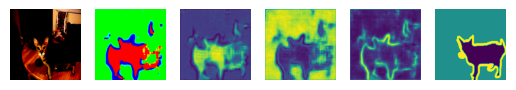

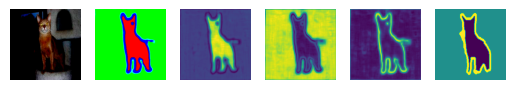

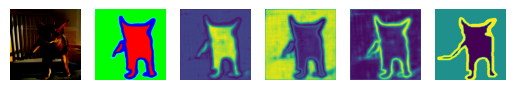

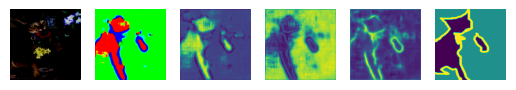

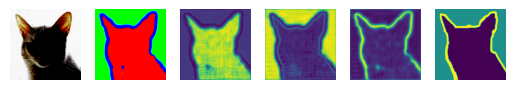

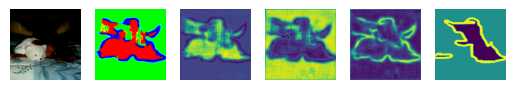

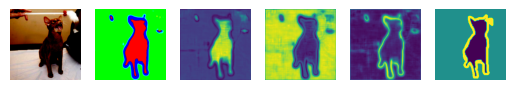

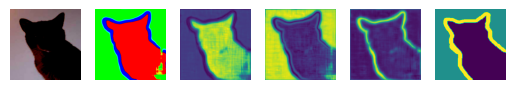

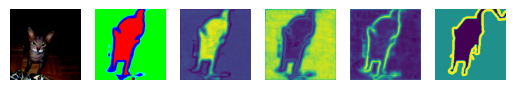

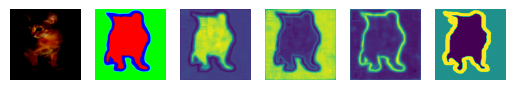

In [15]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     

        f, axarr = plt.subplots(1, 6)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(gen_mask[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(gen_mask[0][0].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        axarr[3].imshow(gen_mask[0][1].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[3].axis('off')
        axarr[4].imshow(gen_mask[0][2].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[4].axis('off')
        axarr[5].imshow(valid_mask.cpu().permute(1, -1, 0).numpy())
        axarr[5].axis('off')